In [1]:
import xarray as xr

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

import warnings 
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
path = './ndviavhrr19812001.nc'
ncfile = xr.open_dataset(path)
print(ncfile)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 252)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:     \nNational Aeronautics and Space Administration advanced ver...
    title:       NASA AVHRR normalized difference vegetation index, 1981-2001
    convention:  The file is written in COARDS-compliant netCDF:\nftp://ftp.u...


# Data Processing

In [3]:
ndvi = ncfile.data_vars['data']
print(ndvi.shape)

#Convert longitude coordinates from 0-359 to -180-179:
#https://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html
#Coordinate를 조정하거나 이미 있는 dimension에 대해 새롭게 coordinate를 만들어 줄 수도 있다. 
ndvi_ = ndvi.assign_coords({"lon" : (((ndvi.lon + 180) % 360) - 180)})
ndvi_ = ndvi_.sortby('lon',ascending=True)

print(ndvi_) #찍어보면 위에랑 longitude 좌표가 바뀐 것을 확인 할 수 있다. 

(252, 180, 360)
<xarray.DataArray 'data' (time: 252, lat: 180, lon: 360)>
[16329600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Attributes:
    units:      non-dimensional
    long_name:  NASA AVHRR normalized difference vegetation index, 1981-2001


### (1) Global Domain

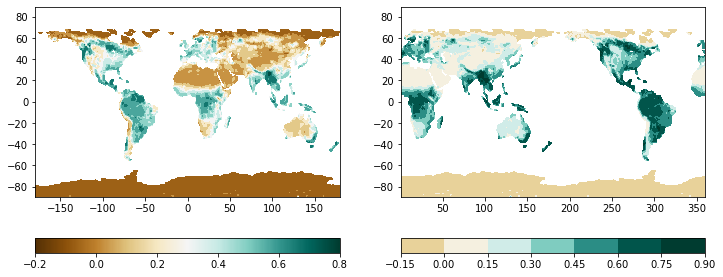

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ndvi_lat_convert = ax[0].contourf(ndvi_.lon, ndvi_.lat, ndvi_[10], cmap=plt.cm.BrBG,
                                 levels=10)
#colorbar 1 : plot단계에서 levels 지정하기
#cbar = fig.colorbar(ndvi_lat_convert, ax=ax[0], location = 'bottom')
#위 처럼 cbar 그리면 discrete한 형식으로 그려짐.

cmap = mpl.cm.BrBG
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.8)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0], orientation='horizontal')
#colorbar 2 : gradient로 그리기
#이렇게 하면 현재 ax[0]의 cbar처럼 gradation으로 그릴 수 있음.
#다만 vmin과 vmax를 따로 지정해주어야함. method1처럼 data값을 인식해서 그리는 것이 아님.
#여기서는 먼저 discrete한 cbar을 그려서 최솟값과 최댓값을 확인한 후
#각 최솟값과 최댓값을 vmin, vmax로 지정해주었다. 
#출처 : https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ndvi_lat_original = ax[1].contourf(ndvi.lon, ndvi.lat, ndvi[10],cmap=plt.cm.BrBG)
ndvi_lat_original.set_clim(-0.5,0.75)
cbar2 = fig.colorbar(ndvi_lat_original,ax=ax[1], location = 'bottom')
#colorbar 3 : set_clim 사용하기.
#colorbar의 max, min값을 지정해 줄 수 있음. 
#하지만 set_clim을 상위 matplot버전에서 지원하지 않는다고함..


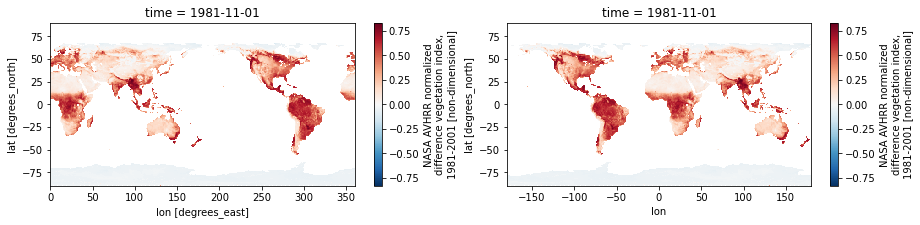

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1) ;ndvi[10].plot()
plt.subplot(1,2,2) ;ndvi_[10].plot()

### (2) Africa Domain

In [6]:
africa = ndvi_.sel(lon=slice(-30,60), lat=slice(40, -40))
print(africa.shape) #(time, lat, lon)
africa

(252, 80, 90)


<xarray.DataArray 'data' (time: 252, lat: 80, lon: 90)>
[1814400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 39.5 38.5 37.5 36.5 35.5 ... -36.5 -37.5 -38.5 -39.5
  * lon      (lon) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 56.5 57.5 58.5 59.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Attributes:
    units:      non-dimensional
    long_name:  NASA AVHRR normalized difference vegetation index, 1981-2001

In [7]:
#climatology
africa_climatology = africa.groupby("time.month").mean("time")
print(africa_climatology.shape)

#anomaly
africa_anomalies = africa_climatology - africa_climatology.mean("month")
#각 달의 climatology에서 전체 연평균을 뺀 거
print(africa_anomalies.shape)

(12, 80, 90)
(12, 80, 90)


# Visualization

### (1) Plot Africa NDVI

In [8]:
def plot_africa_NDVI(ax, month):
    m = Basemap(
        lon_0 = 0, lat_0 = 0, 
        llcrnrlon=-30, llcrnrlat=-40, urcrnrlon=60, urcrnrlat=40,
        resolution='h',
        ax=ax)
    
    index=month-1
    
    coord = np.meshgrid(africa_climatology.lon, africa_climatology.lat)
    m.drawcoastlines(linewidth=0.5, color='k')
    m.drawcountries(linewidth=0.5, color='k') # draw country line
    m.drawparallels(np.linspace(-40,40,5), labels=[1,0,0,0], linewidth=0., fontsize=5) # draw horizontal grid line
    m.drawmeridians(np.linspace(-30,60,5), labels=[0,0,0,1], linewidth=0., fontsize=5) # draw vertical grid line
    ndvi_contourf = m.contourf(coord[0], coord[1], africa_climatology[index],cmap=plt.cm.BrBG,
                              levels = 20)
    ax.set_title(month)
    
    #return ndvi_contourf

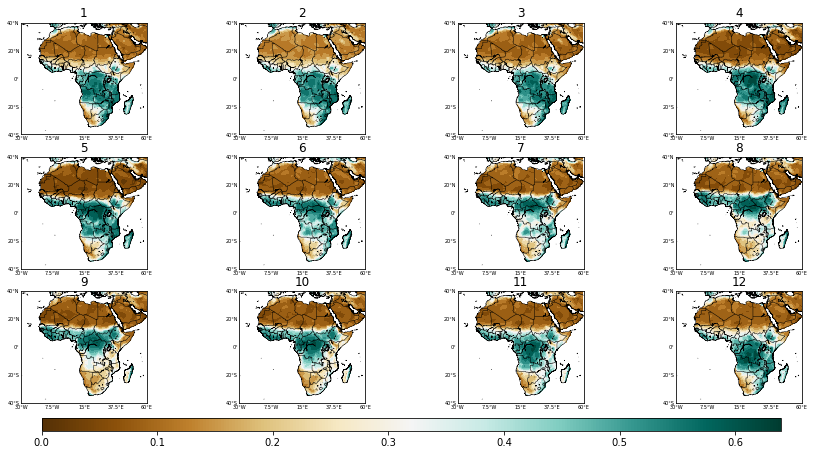

In [9]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,7))
#plt.subplots_adjust(wspace=0.0, hspace=0.2)


mo = 1
for row in range(3):
    for col in range(4):
        plot = plot_africa_NDVI(ax[row][col], mo)
        mo+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])        
cmap = mpl.cm.BrBG
norm = mpl.colors.Normalize(vmin=0., vmax=0.64)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')        